# Exploratory Data Analysis and Clustering Workshop: 13th June 2019

![title](images/pydata_cardiff.jpg)

This is the first workshop presented at PyData Cardiff. It will outline a few of the techniques that I have used since starting working as a data scientist a number of years ago. The intention of this was to share some of the tips and tricks that I have found have helped me on a number of occasions in different positions.

The outline of this workshop:

* Introduction to both K-Means Clustering and Gaussian Mixture Models
* Suitable metrics to judge the performance of clustering models
    * Also a brief discussion on how this can be difficult
* An introduction to using Principle Component Analysis to reduce dimensionality in datasets
* Using hierarchical clustering to search for possible patterns in your datasets

## Main aims:

As the duration of this workshop will be quite short, the main goal is to provide an introduction and overview of these techniques. An in depth analysis into how these algorithms work has been omitted in favour of providing examples and possible use cases of the techniques.

#### Important point:

All of the methods used here assume _complete_ datasets with _no missing values_. If these are present, then methods must be used to address this beforehand. In the interest of time, these cannot be shown in this workshop

## Importing the libraries

This first cell will import the main libraries that we will need. However, specific libraries and functions that are discussed in more detail are imported as they are used

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import iplot, init_notebook_mode
from sklearn.datasets import make_blobs
%matplotlib inline

In [2]:
init_notebook_mode(connected=True) # This allows us to use interactive Plotly images without connecting to their server

In [3]:
# Useful code snippet to change the layout of the notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Creating our first dataset and visualising the output

This data being creating is entirely synthetic data, purely used for example purposes. The `make_blobs` function from scikit-learn is used to create these clusters with 2 features. This function returns 2 values:

* An array of size _n_samples_ (rows) by _n_features_ (columns)
* A 1D array of the cluster labels

In [4]:
np.random.seed(111)
data, blobs = make_blobs()
x = data[:, 0]
y = data[:, 1]

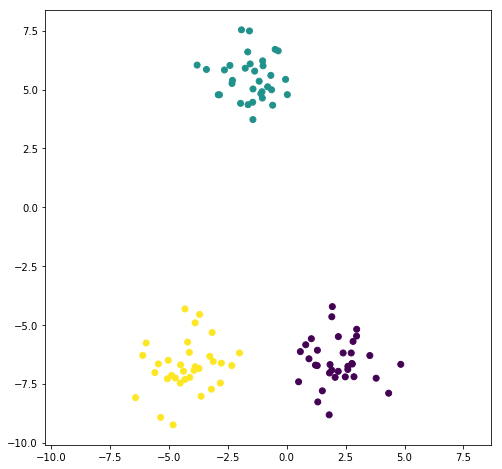

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, c=blobs)
ax.axis('equal');

# K-Means clustering

The first technique that we will look at is K-Means clustering. It is a simple and fast method that is carried out as follows:

* The user specifies the number of clusters that the model should consider
* This number is used to assign random points throughout the data space
* These points can be thought of as the 'starting seeds' of the clusters
* The following steps are then iterated:
    * Each datapoint is assigned to a cluster based on the closest seed point (random at stage 1)
    * The seed point is then moved to the centre point of the respective clusters
    * This point is known as the __Centroid__ (this term will now be used instead of 'seed'
    * This acts as the new seed point, which has a different location, and the process is repeated
* Note that, as these centroids are being moved around, the original data points can shift between assigned clusters, which moves the centroids again, etc...
* This process is repeated until convergence - or until no further productive progress is made

This process is an example of an __Expectation-Maximisation (EM)__ Algorithm:

* __E Step__ The data points are assigned to the cluster of the closest centroid
* __M Step__ The centroid is moved to the centre of all the data points that have been assigned to it _on this iteration_

#### Stochastic Element

Note that, as the initial centroid locations are chosen at random, there will be variation in the outputs from different runs of the model.

## Let's see it in action:

As this is the first example, I am choosing 3 starting points for the 3 clusters, so we can see the ideal situation

In [6]:
from sklearn.cluster import KMeans

In [7]:
km3 = KMeans(n_clusters=3)
km3.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [8]:
clusters3 = km3.labels_
centroids3 = km3.cluster_centers_

We can see that each datapoint has been assigned to one of the clusters, and we can also obtain the final __centroids__

In [9]:
clusters3

array([2, 1, 1, 0, 0, 2, 2, 0, 0, 0, 0, 1, 1, 1, 0, 2, 0, 2, 0, 1, 2, 0,
       0, 2, 2, 1, 1, 2, 0, 1, 1, 2, 0, 2, 2, 1, 1, 2, 2, 2, 2, 0, 2, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 0,
       2, 1, 1, 1, 0, 2, 0, 2, 1, 2, 1, 0, 0, 1, 2, 0, 0, 2, 1, 1, 0, 2,
       0, 1, 2, 1, 2, 1, 2, 0, 1, 0, 0, 1], dtype=int32)

In [10]:
centroids3

array([[ 2.19208948, -6.56898643],
       [-1.53265553,  5.47989902],
       [-4.23142155, -6.76250802]])

From looking at the outcome, it is apparent that the algorithm has worked effectively. The centroids can be seen with the red crosses

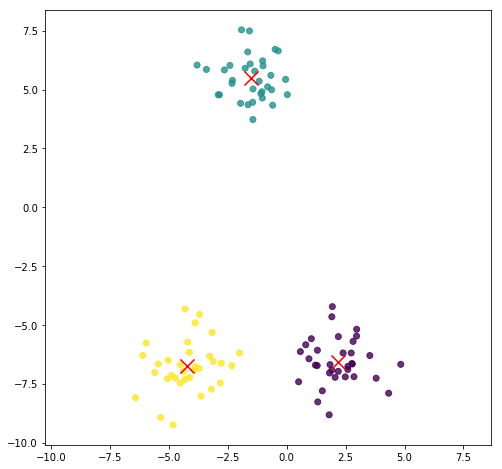

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, c=km3.labels_, alpha=0.8)
ax.scatter(centroids3[:, 0], centroids3[:, 1], c='red', marker='x', s=200)
ax.axis('equal');

## Running the algorithm with an "incorrect" number of clusters

This next example shows the outcome of starting out with a sub-optimal number of cluster seed points.

The result can seen very intuitive - but try to imagine what the outcome can be before you run the cell.

In [12]:
km2 = KMeans(n_clusters=2)
km2.fit(data)
clusters2 = km2.labels_
centroids2 = km2.cluster_centers_

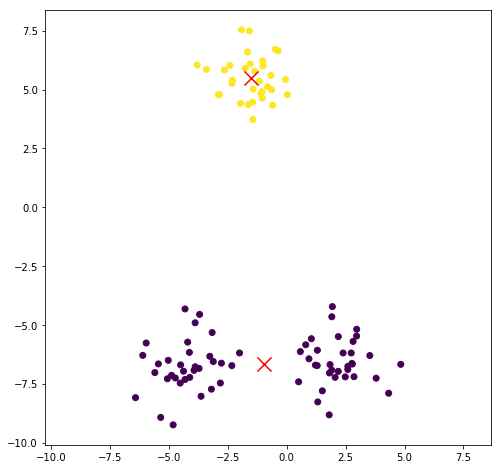

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, c=km2.labels_)
ax.scatter(centroids2[:, 0], centroids2[:, 1], c='red', marker='x', s=200)
ax.axis('equal');

As is apparent from the visualisation - the bottom 2 clusters have been combined into 1, as the model is restricted to using 2 clusters only. The resulting centroid appears in the middle of these

# An example metric for clustering performance

When we wish to perform clustering of our data, using algorithms such as K-Means, we will normally have _unlabeled_ data, meaning that we do not know in advance which cluster the data points should belong to. If we had this information in advance, then we could make use of powerful supervised learning algorithms, like random forests and deep neural networks.

Instead, we normally need to find a way of assessing how well the clustering if working. We cannot just rely on plotting the data, as this would not be possible as soon as we go above 3 features. One such metric that can assess performance, without knowing the ground-truth labels, is the __silhouette score__. This metric works by comparing the _within-cluster_ variance compared to the _between-cluster_ variance to the next nearest cluster. In short, if the data points are (in general) closer to the other data points in their assigned clusters compared to the other data points, the metric will report better performance. The metric ranges from -1 (bad) to 1 (good).

Here we can see that the metric prefers the model with the 3 clusters:

In [14]:
from sklearn.metrics import silhouette_score

In [15]:
silhouette_score(data, clusters3)

0.7650972612137333

In [16]:
silhouette_score(data, clusters2)

0.7311505722697456

## Making a new dataset with unclear clusters

The previous example provided very clear cut clusters, which the model identified with ease. This next dataset shows a different case, one which is far more commonly seen in real data. In this case, 2 of the clusters are almost blurring into each other.

In [17]:
blob_centers = np.array([[-4.5, -4.5], [-7, -7], [-3, 3]])
data_overlap, blob_overlap = make_blobs(n_samples=600, centers=blob_centers)
x_overlap = data_overlap[:, 0]
y_overlap = data_overlap[:, 1]

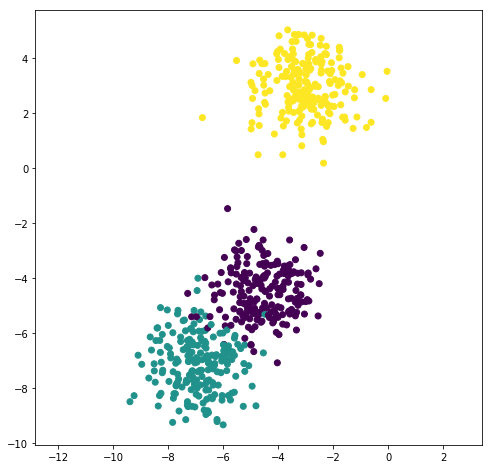

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x_overlap, y_overlap, c=blob_overlap)
ax.axis('equal');

While we can see the 3 different colours here, if these weren't here, then we might intuitively see 2 clusters instead of 3. Let's try running the algorithm with 3 and 2 clusters, and assess the performance:

In [19]:
km_overlap3 = KMeans(n_clusters=3)
km_overlap3.fit(data_overlap)
clusters_overlap3 = km_overlap3.labels_
centroids_overlap3 = km_overlap3.cluster_centers_

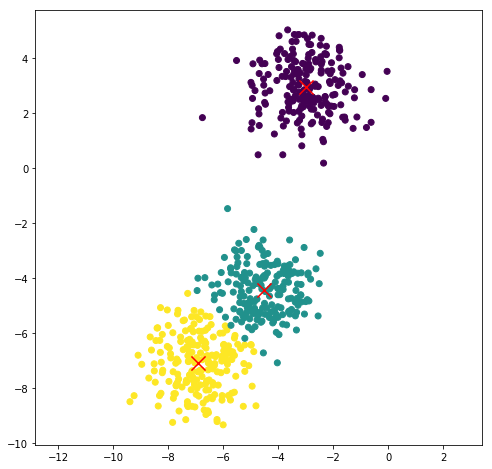

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x_overlap, y_overlap, c=clusters_overlap3)
ax.scatter(centroids_overlap3[:, 0], centroids_overlap3[:, 1], c='red', marker='x', s=200)
ax.axis('equal');

In [21]:
km_overlap2 = KMeans(n_clusters=2)
km_overlap2.fit(data_overlap)
clusters_overlap2 = km_overlap2.labels_
centroids_overlap2 = km_overlap2.cluster_centers_

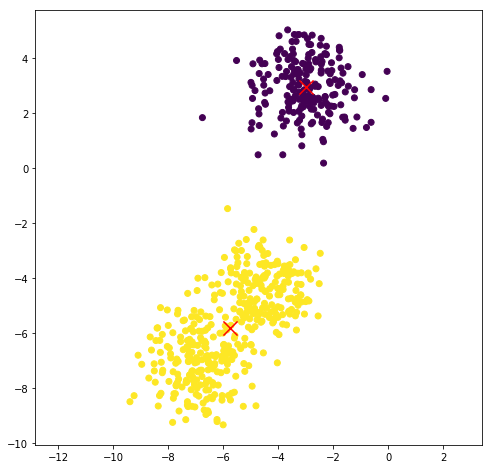

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x_overlap, y_overlap, c=clusters_overlap2)
ax.scatter(centroids_overlap2[:, 0], centroids_overlap2[:, 1], c='red', marker='x', s=200)
ax.axis('equal');

In [23]:
silhouette_score(data_overlap, clusters_overlap3)

0.6149791353839875

In [24]:
silhouette_score(data_overlap, clusters_overlap2)

0.7282411982486433

These results show that the metric does prefer using 2 clusters to 3, and that these metrics can really be of assistance when trying to explore the parameters required for any clustering, as your data will not always be easily plotted

# Gaussian Mixture Models

One key point of K-Means is that it assumes that the clusters are _isotropic_: it has the same size when measured from all directions. In 2 dimensions, this means a circle, and in 3 it means a sphere (it higher dimensions - a _hyper_ sphere).

The following data shows some data that does not display this property. It has been created using matrix transformations in numpy, using the `@` operator. Don't worry if you are not clear on how this works. This is a transformation of the previous dataset, and I have also added in another cluster, which has the variance in a different direction. We will then see how a Gaussian Mixture Model can deal with this data.

In [25]:
trm = np.array([[3, -0.8], [-0.8, 1]])
gaussian_overlap = data_overlap @ trm
gaussian_extra = make_blobs(n_samples=200, centers=np.array([[0, 0]]))[0] @ np.array([[4, 1], [1, 1]]) + np.array([-20, 10])
gaussian_overlap_all = np.vstack([gaussian_overlap, gaussian_extra])
x_gaussian = gaussian_overlap_all[:, 0]
y_gaussian = gaussian_overlap_all[:, 1]

In [26]:
blob_overlap_all = np.append(blob_overlap, 200 * [3])

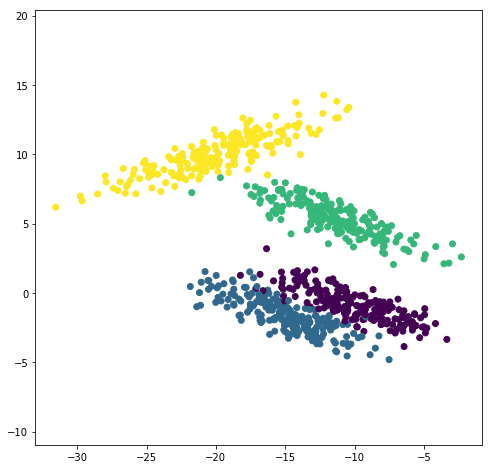

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x_gaussian, y_gaussian, c=blob_overlap_all)
ax.axis('equal');

## Trying K-Means first

Here I am just using the K-Means algorithm to see what happens. In the interest of time, I am specifying the correct number of clusters. Remember that, in real life, you would have to experiment to find these values.

In [28]:
k_means_gaussian = KMeans(n_clusters=4)
k_means_gaussian.fit(gaussian_overlap_all)
g_centroids = k_means_gaussian.cluster_centers_

This shows that the algorithm is not finding those original clusters

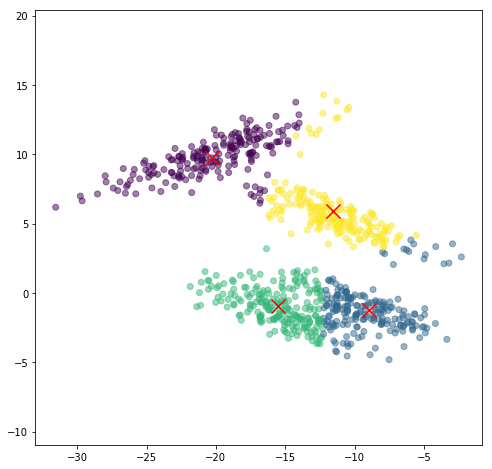

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x_gaussian, y_gaussian, c=k_means_gaussian.labels_, alpha=0.5)
ax.scatter(g_centroids[:, 0], g_centroids[:, 1], marker='x', c='red', s=200)
ax.axis('equal');

## Trying out the GMM

The advantage of this algorithm is that it does not require the data to be isotropic - it is capable of fitting _ellipsoids_, and the results can be as follows. Note that we are now using the `predict` method on the fitted object in order to get the cluster labels.

In [30]:
from sklearn.mixture import GaussianMixture

In [31]:
gmm = GaussianMixture(n_components=4)
gmm.fit(gaussian_overlap_all)
g_clusters = gmm.predict(gaussian_overlap_all)

## Results

The below plot shows that the model has recovered the shapes correctly!

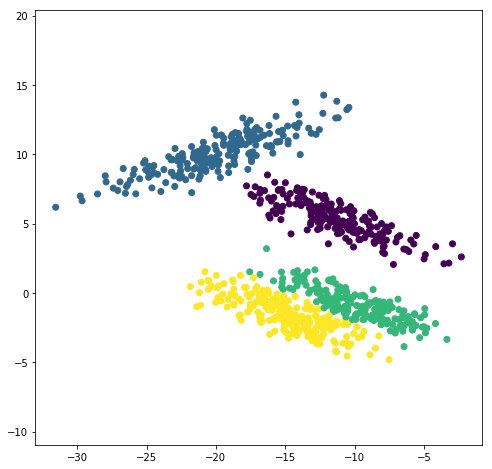

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x_gaussian, y_gaussian, c=g_clusters)
ax.axis('equal');

## Testing the model on new data points

Previously, when recovering the cluster labels from the fitted model, we used the `predict` method on the `gmm` object. This gave us a so called __hard__ cluster value. However, one of the features of a GMM is that it is able to provide the probabilities of cluster membership.

This next cell shows some points (with the red triangles) that did not play a role in fitting the model, but are assigned cluster probabilities. As you can see, there are some that are clear members of certain clusters, and others where this is more ambiguous:

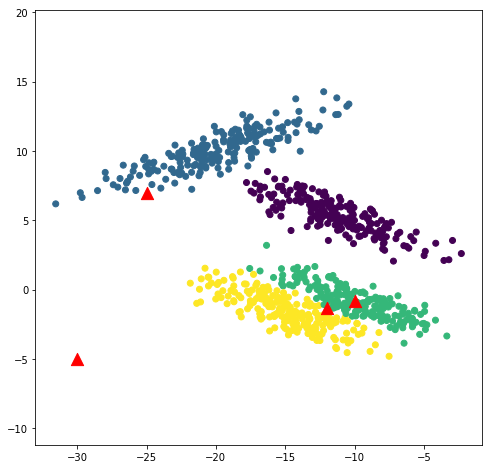

In [33]:
test_data = np.array([[-25, 7], [-10, -0.8], [-12, -1.3], [-30, -5]])

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x_gaussian, y_gaussian, c=g_clusters)
ax.scatter(test_data[:, 0], test_data[:, 1], c='red', marker='^', s=150)
ax.axis('equal');

The predictions are shown from the top point down to the bottom. The results from this require some explanation:

* Point 1 definitely belongs to the blue cluster, while it is on the edge, there is no other feasible cluster even close
* Point 2 almost certainly belongs to the purple cluster, but the fitted ellipsoid from the yellow cluster is making a tiny claim to it
* Point 3 is pretty much split 50/50 between yellow and purple
* Point 4 belongs to the yellow cluster
    * While this might look strange, it is because there is no other viable contender

In [34]:
gmm_predictions = gmm.predict_proba(test_data).round(3)
gmm_predictions

array([[0.   , 1.   , 0.   , 0.   ],
       [0.   , 0.   , 0.997, 0.003],
       [0.   , 0.   , 0.497, 0.503],
       [0.   , 0.   , 0.   , 1.   ]])

There is also a `score_samples` method, which gives the log-probability of the point. Think of this as how certain a point falls within a cluster. As it is a log value, we can take the exponent of this.

These numbers might look strange here, and a full explanation of the probability values is beyond this workshop. The main thing to notice is that the point 4, while there is only 1 cluster that it can belong to, its probability value is incredibly low

In [35]:
np.exp(gmm.score_samples(test_data))

array([9.86703056e-04, 1.92282351e-02, 6.74561421e-03, 5.67680642e-32])

## Providing metrics for these clusterings

This next example shows the difficulty that can arise when trying to assess the performance of the different methods, using the different parameters like the number of clusters. In the following example, we can see the results from the silhoutte metric that was used before, but also from another metric, which does make use of the provided labels. This is called the __Homogeneity Score__.

It needs to be stressed here that these labels will normally __not__ be available.

In [36]:
silhouette_score(gaussian_overlap_all, k_means_gaussian.labels_)

0.48186602356110625

In [37]:
silhouette_score(gaussian_overlap_all, g_clusters)

0.397243056290386

The silhoutte score has actually preferred the results from using K-Means!

In [38]:
from sklearn.metrics import homogeneity_score

In [39]:
homogeneity_score(blob_overlap_all, k_means_gaussian.labels_)

0.6885503249026375

In [40]:
homogeneity_score(blob_overlap_all, g_clusters)

0.9277303118229167

However, when provided with the ground truth labels, it is clear that the GMM is performing better.

### Bayes Information Criteria (BIC)

Fortunately, there is another metric available when using the GMM, and this is the __BIC__. While a full explanation cannot be given here, the key point is that _the lower the value, the better the fit_.

I have run this notebook a number of different times, and due to the stochastic element of the algorithm, it alternates between prefering 4 and 5 clusters! This highlights the difficulty that can arise when performing clustering.

In [41]:
gmm2 = GaussianMixture(n_components=2)
gmm2.fit(gaussian_overlap_all)
gmm2.bic(gaussian_overlap_all)

8955.528899959303

In [42]:
gmm3 = GaussianMixture(n_components=3)
gmm3.fit(gaussian_overlap_all)
gmm3.bic(gaussian_overlap_all)

8304.968043605622

In [43]:
gmm4 = GaussianMixture(n_components=4)
gmm4.fit(gaussian_overlap_all)
gmm4.bic(gaussian_overlap_all)

8237.956353533344

In [44]:
gmm5 = GaussianMixture(n_components=5)
gmm5.fit(gaussian_overlap_all)
gmm5.bic(gaussian_overlap_all)

8284.10363021888

In [45]:
gmm6 = GaussianMixture(n_components=6)
gmm6.fit(gaussian_overlap_all)
gmm6.bic(gaussian_overlap_all)

8304.95287760963

# Principle Component Analysis (PCA)

PCA is a very popular technique, and it can only be introduced briefly here. The main aim is that it seeks to find aspects of the data that show the _maximum amount of observed variance_. While this can seem complicated, it can be seen in an illustration.

In the following diagram, it can be seen that the majority of the pattern in this data goes along a diagonal line. There is variability in the orthogonal (right-angled direction), but this is clearly much smaller.

In [46]:
np.random.seed(122)
single_iso = make_blobs(n_samples=500, n_features=2, centers=np.array([[0, 0]]))[0]
trm_single = np.array([[5, 2], [3, 3]])
single_data = single_iso @ trm_single
x_single = single_data[:, 0]
y_single = single_data[:, 1]

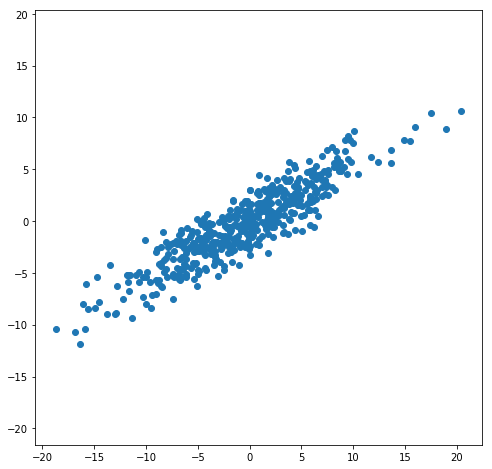

In [47]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x_single, y_single)
ax.axis('equal');

## Visualising the components

Here we fit a model with 2 components. Normally, the idea behind a PCA is that we _reduce_ the number of input features required to represent the data, but this is done here for illustrative purposes

In [48]:
from sklearn.decomposition import PCA

In [49]:
pca_single = PCA(n_components=2)
pca_single.fit(single_data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

The following code makes use of a function that is taken from the fantastic Data Science Handbook by Jake VanderPlas (https://jakevdp.github.io/PythonDataScienceHandbook/)

This aims to show the vectors of the components, namely the direction and the magnitude of their influence

In [50]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=3,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

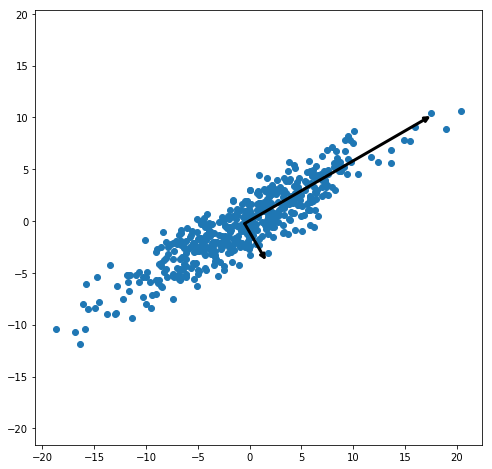

In [51]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x_single, y_single)

for length, vector in zip(pca_single.explained_variance_, pca_single.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca_single.mean_, pca_single.mean_ + v)
plt.axis('equal');

## Changing the required variance

A really nice feature of the `PCA` function from scikit-learn is that, rather than specifying the number of required components, you can specify the proportion of variance explained that you wish to retain. This quick example shows that if we want 99% of the variance, then we need to have the original 2 dimensions, but if we only need 95%, then this can be explained with only 1.

In [52]:
pca_single = PCA(n_components=0.99)
pca_single.fit(single_data)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [53]:
pca_single.n_components_

2

In [54]:
pca_single = PCA(n_components=0.95)
pca_single.fit(single_data)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [55]:
pca_single.n_components_

1

This next section shows what the data looks like when we have lost this amount of information

In [56]:
pca_space_data = pca_single.transform(single_data)

In [57]:
transformed_data = pca_single.inverse_transform(pca_space_data)
x_transformed = transformed_data[:, 0]
y_transformed = transformed_data[:, 1]

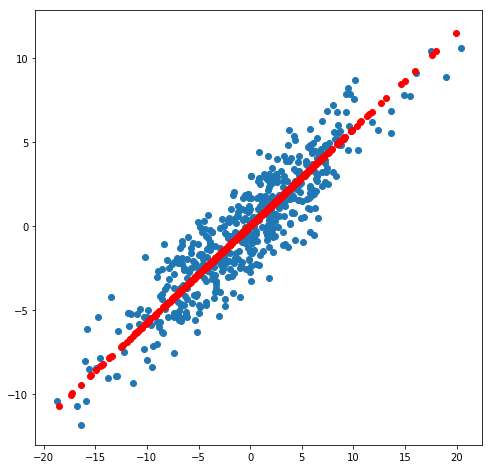

In [58]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x_single, y_single)
ax.scatter(x_transformed, y_transformed, c='red');

## Dimensionality reduction

The next cells show a visualisation of how a set of clusters in 3 dimensions can clearly be represented by only 2. The 3d graph is interactive, so you can use the mouse to rotate it around and view from different angles

In [59]:
np.random.seed(99)
data, blobs = make_blobs(n_samples=600, n_features=3)

In [60]:
color_dict = {1: 'darkolivegreen',  2: 'darkorange', 3: 'steelblue'}

In [61]:
blob_colors = np.array([color_dict[c] for c in blobs+1])

In [62]:
trace1 = go.Scatter3d(
    x=data[:, 0],
    y=data[:, 1],
    z=data[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=blob_colors,
        colorscale='viridis',
        opacity=0.8,
        line=dict(
            color='black',
            width=1
        )
    )
)

plot_data = [trace1]
layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
fig = go.Figure(data=plot_data, layout=layout)

In [63]:
iplot(fig)

In [64]:
pca2d = PCA(n_components=0.95)
plot_data = pca2d.fit_transform(data)

95% of the variance can indeed be seen in 2 dimensions. You can also rotate the 3d image so that it looks the same as the plot below

In [65]:
pca2d.n_components_

2

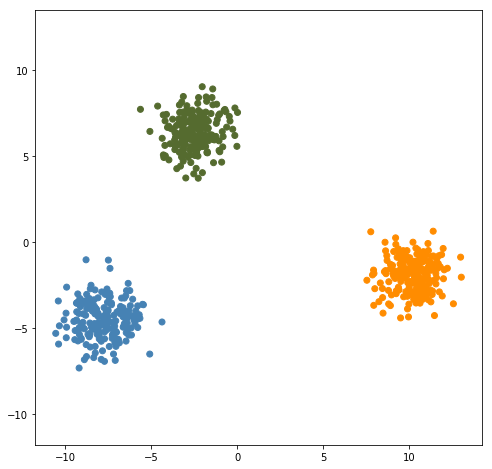

In [66]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(plot_data[:, 0], plot_data[:, 1], c=blob_colors)
ax.axis('equal');

## Use in a real dataset

Here, the method is used on the wine dataset that is built into scikit-learn. This is a dataset that contains information about 13 features of different samples of wine. This is also a labelled dataset, and contains information about the rated quality of each wine. This can be used for building regression models, but in this case, we are just looking at the input features.

In [67]:
from sklearn.datasets import load_wine

In [68]:
wine = load_wine()

In [69]:
wine_df = pd.DataFrame(data=wine['data'], columns=wine['feature_names'])

## Normalising the data!

Now that we are using real data, a very important point must be made about PCA. It requires that the data features have similar means and variances. As can be seen below, some of these features are fractions below 1, while others are up into the thousands.

In [70]:
wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


The following code get the normalised _z-scores_ from the data

In [71]:
wine_df_norm = (wine_df - wine_df.mean()) / wine_df.std()

## Dropping the dimensions

The following cells show that out of the 13 original features, we only require 8 if we want to capture 90% of the explained variance. When looking at the cumulative amount explained (using the `cumsum` method from numpy on the `explained_variance_ratio` of the fitted PCA object), it can be seen that by the time we get to 4 components, we have nearly accounted for 75%

In [72]:
wine_pca95 = PCA(n_components=0.9)
wine_pca95.fit(wine_df_norm.values)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [73]:
wine_pca95.n_components_

8

In [74]:
wine_pca95.explained_variance_ratio_.cumsum()

array([0.36198848, 0.55406338, 0.66529969, 0.73598999, 0.80162293,
       0.85098116, 0.89336795, 0.92017544])

# So what?

Indeed... what is the point of all this? We still cannot visualise 8, or 4, dimensions, so what is it achieving?

### Dimension reduction

While in this case, 13 features is not _too many_ to deal with, there can be cases when you have an extremely large number of datapoints; sometimes more than the number of samples that you have. In these circumstance, PCA can really help.

### Getting uncorrelated features

As could be seen in the arrows in the scatter plot a few cells back; the components are always _orthogonal_ to each other. This means that these are alway __uncorrelated__. In many cases, the presence of correlated features can make machine learning and other statistical methods struggle. The term for this is called _multi-collinearity_. Basically, if you have multiple features that are saying similar things, it can be difficult for the model to identify where any predictive information is coming from. This is especially relevant in models that can be used to explain the contributions from the features, like Random Forests and Multiple Regression.

The following plots show that PCA removes this correlation completely.

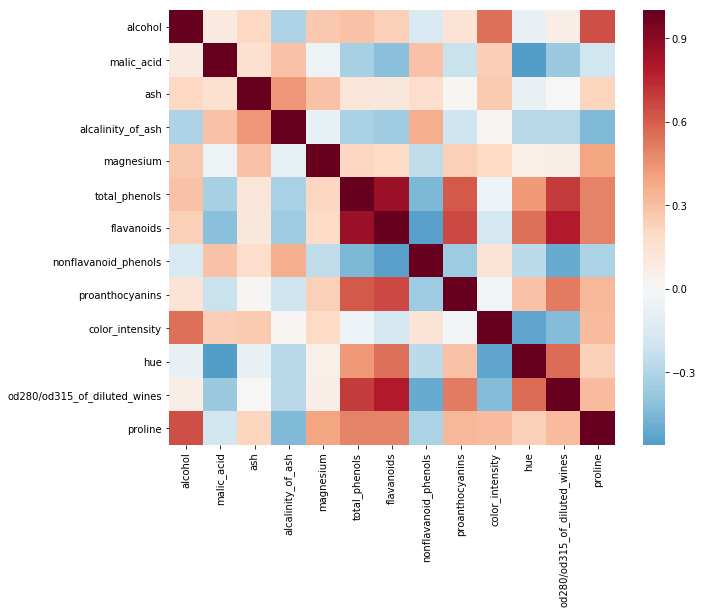

In [75]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(wine_df.corr(), ax=ax, cmap='RdBu_r', center=0);

In [76]:
wine_pca95_values = wine_pca95.transform(wine_df_norm.values)
wine_pca95_components = ['pca_{}'.format(x+1) for x in range(wine_pca95.n_components_)]

In [77]:
wine_pca95_df = pd.DataFrame(data=wine_pca95_values, columns=wine_pca95_components)

In [78]:
wine_pca_component_df = pd.DataFrame(
    data=wine_pca95.components_.T,
    columns=wine_pca95_components,
    index=wine_df.columns
)

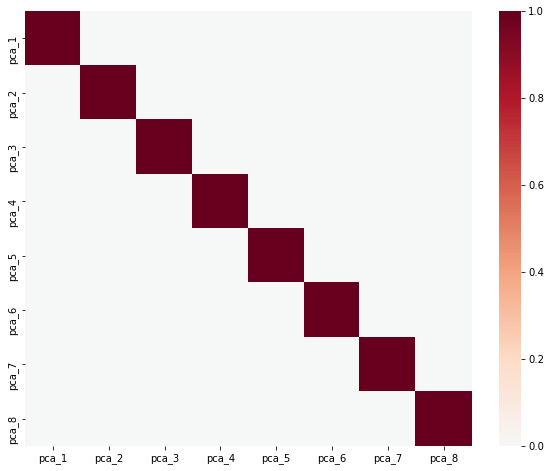

In [79]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(wine_pca95_df.corr(), ax=ax, cmap='RdBu_r', center=0);

## Caveat of this method

While this data preparation has provided more suitable input to be used to train the model, it can make the interpretation more difficult as now the model is using the _Principle Components_. So the model could not tell you that "Principle Component 3 is really important!" for example. Great... what does that mean? Well, it can be hard, but it is very possible to understand this, as you can examine how the original features _load-onto_ the components using the `components_` attribute of the fitted PCA object. Unfotunately, an explanation of this is outside the scope of this workshop.

# Clustermapping

Here I will provide a few examples of one of my favourite Python functions ever: `clustermap` from the `seaborn` visualisation library. I think that it is just brilliant as (provided you don't have missing data points), it can be easily used to immediately see if there are any patterns in your data.

The first example will look at the clusters observed when looking at the correlation of the wine features used earlier.

On the top and the left, you can see the _dendrograms_ of the data. These show the structures of the clusters. Note that when the _branch_ between 2 points is lower down, this means that the points are more closely related to each other. As this is a clustering of the correlation matrix, the pattern is the same for both the top and the side.

Note the following points:

* This is using the 'Ward' method to calculate the clusters, you can also use different distance metrics for this function, but this one requires that the distance is Euclidean
* I like the colour map (`cmap`) of `RdBu_r` with the centering at 0 as this shows positive correlations in Red, and negative ones in blue

Also examine the different clusters, and how they are related to each other. When looking at the dendrogram, it also looks as though there are 3 or possibly 4 clusters visible. Go back and look at how this relates to the cumulative variance explained in the PCA

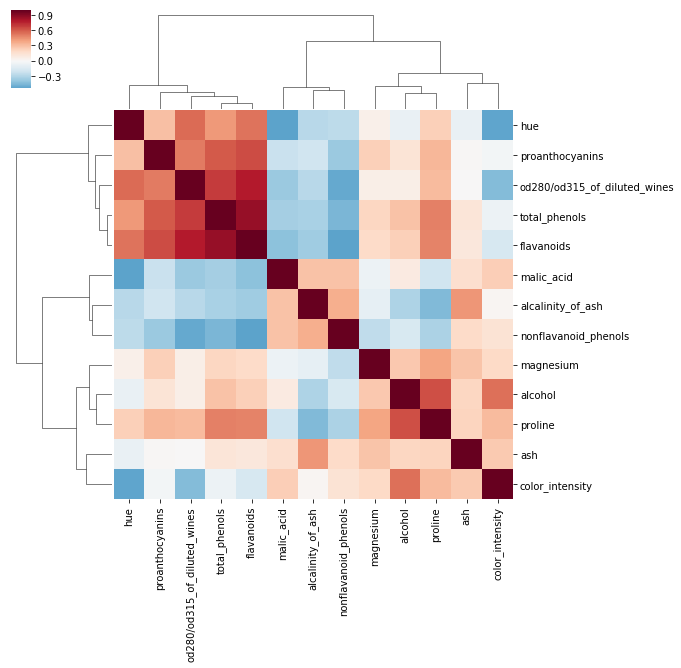

In [80]:
sns.clustermap(
    data=wine_df.corr(),
    method='ward',
    cmap='RdBu_r',
    center=0,
    robust=True,
    figsize=(9, 9)
);

The following lines of code show how we can use scipy to identify these clusters. For a more detailed explanation, please look at the following blog, which I found invaluable when learning these techniques: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [81]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
wine_linkage = linkage(wine_df.corr(), method='ward')

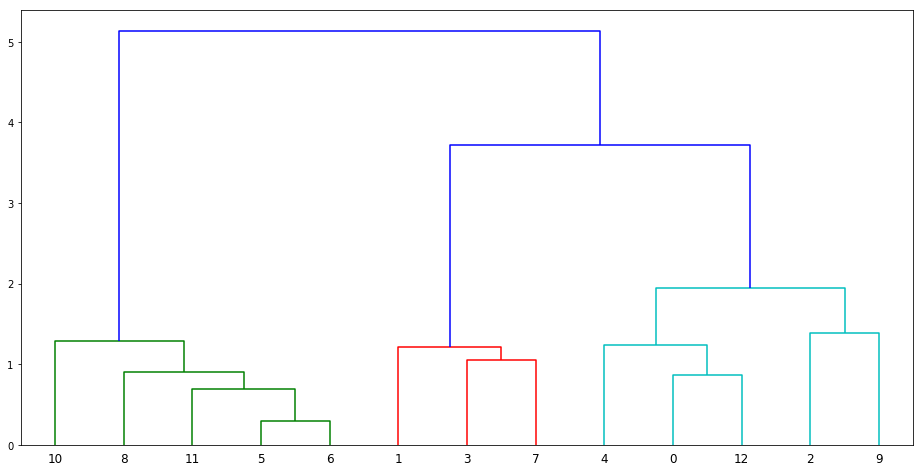

In [82]:
fig, ax = plt.subplots(figsize=(16, 8))
dendrogram(
    wine_linkage,
)
plt.show()

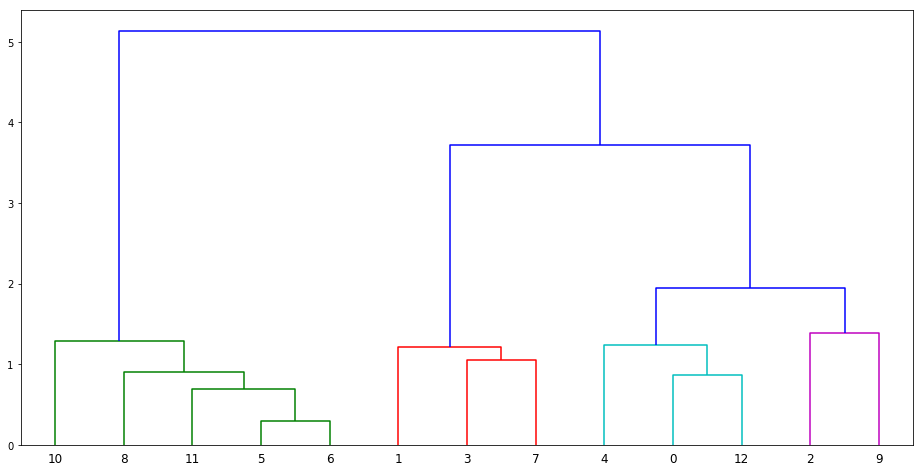

In [83]:
fig, ax = plt.subplots(figsize=(16, 8))
dendrogram(
    wine_linkage,
    color_threshold=1.5
)
plt.show()

In [84]:
wine_clusters = fcluster(wine_linkage, 4, criterion='maxclust')

In [85]:
wine_cluster_df = pd.DataFrame({'feature': wine_df.columns, 'clusters': wine_clusters})

In [86]:
wine_cluster_df.sort_values('clusters')

,clusters,feature
5,1,total_phenols
6,1,flavanoids
8,1,proanthocyanins
10,1,hue
11,1,od280/od315_of_diluted_wines
1,2,malic_acid
3,2,alcalinity_of_ash
7,2,nonflavanoid_phenols
0,3,alcohol
4,3,magnesium


## Clustering samples:

We can also use this method to look at how the different samples cluster together. However, it is important to note that this method can start to fail if you have hundreds of thousands, or millions, of samples. Sadly, it is not a silver-bullet... but when it works, it is fantastic!

It really looks like there are 3 different clusters of wine type observed here.

Note that this is using the normalised data in order to get the features clustering properly. Try swapping out the `wine_df_norm` for `wine_df` to see the effect if this isn't done!

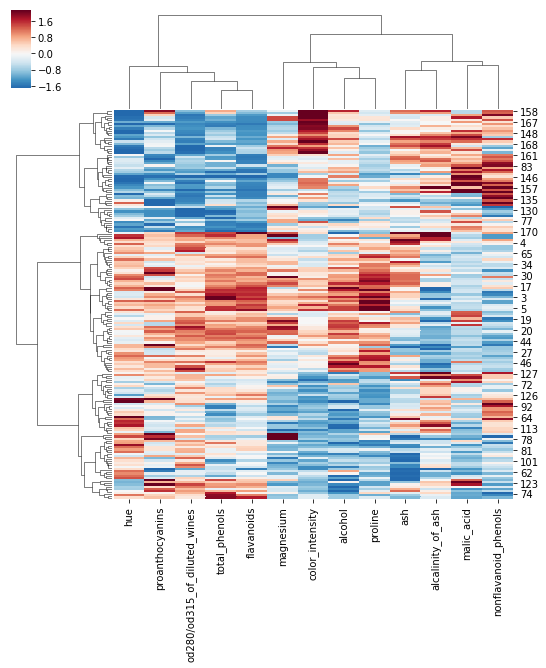

In [87]:
wine_df_norm = (wine_df - wine_df.mean()) / wine_df.std()

sns.clustermap(
    data=wine_df_norm,
    method='ward',
    cmap='RdBu_r',
    center=0,
    robust=True,
    figsize=(9, 9)
);

## Larger data

The following is a simplified variation of an example provided in the Seaborn documentation pages. Note that, as there are so many features now, not all of the information is shown in the text of the axes.

In [88]:
brain_network_df = sns.load_dataset("brain_networks", header=[0, 1, 2], index_col=0)

In [89]:
brain_network_df.head()

network          1                     2                     3             \
node             1                     1                     1              
hemi            lh         rh         lh         rh         lh         rh   
0        56.055744  92.031036   3.391576  38.659683  26.203819 -49.715569   
1        55.547253  43.690075 -65.495987 -13.974523 -28.274963 -39.050129   
2        60.997768  63.438793 -51.108582 -13.561346 -18.842947  -1.214659   
3        18.514868  12.657158 -34.576603 -32.665958  -7.420454  17.119448   
4        -2.527392 -63.104668 -13.814151 -15.837989 -45.216927   3.483550   

network          4                     5               ...             16  \
node             1                     1               ...              3   
hemi            lh         rh         lh         rh    ...             rh   
0        47.461037  26.746613 -35.898861  -1.889181    ...       0.607904   
1        -1.210660 -19.012897  19.568010  15.902983    ...      57.495071   
2       -65.575806 -85.777428  19.247454  37.209419    ...      28.317369   
3       -41.800869 -58.610184  32.896915  11.199619    ...      71.439629   
4       -62.613335 -49.076508  18.396759   3.219077    ...      95.597565   

network                                17                                   \
node             4                      1                     2              
hemi            lh          rh         lh         rh         lh         rh   
0       -70.270546   77.365776 -21.734550   1.028253   7.791784  68.903725   
1       -76.393219  127.261360 -13.035799  46.381824 -15.752450  31.000332   
2         9.063977   45.493263  26.033442  34.212200   1.326110 -22.580757   
3        65.842979  -10.697547  55.297466   4.255006  -2.420144  12.098393   
4        50.960453  -23.197300  43.067562  52.219875  28.232882 -11.719750   

network                                    
node             3                      4  
hemi            lh          rh         lh  
0       -10.520872  120.490463 -39.686432  
1       -39.607521   24.764011 -36.771008  
2        12.985169  -75.027451   6.434262  
3       -15.819172  -37.361431  -4.650954  
4         5.453649    5.169828  87.809135  

[5 rows x 62 columns]

There are 62 features in this dataset

In [90]:
brain_network_df.shape

(920, 62)

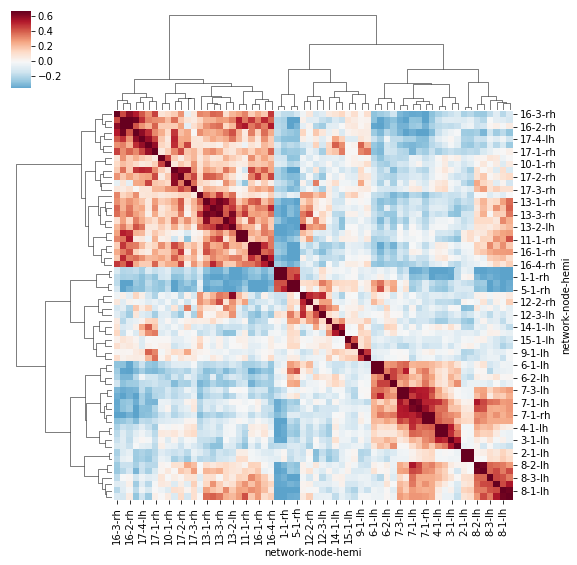

In [91]:
sns.clustermap(
    brain_network_df.corr(),
    method='ward',
    robust=True,
    cmap='RdBu_r',
    center=0, 
    figsize=(9, 9)
);

# Stocks of interest

So far, all of the datasets have either been synthetic, or included with libraries for training purposes. Now we can look at how the clustering performs of real data. End of day data (Open-High-Low-Close) from the following stocks was downloaded:

* Tech Stocks
    * Microsoft MSFT
    * Apple AAPL
    * Facebook FB
    * Netflix NFLX
    * Google GOOGL
    * Twitter TWTR
    * Oracle ORCL
    * Amazon AMZN
    * Paypal PYPL
    * Tesla TSLA
* Pharma Stocks
    * Pfizer PFE
    * Eli Lilly LLY
    * Glaxo GSK
    * Novartis NVS
    * Merck MRK
    * Sanofi GCVRZ

This was done using the following code - but this can have temporamental performance, so I prepared a csv file for use here. This was run on the 7th of June 2019

In [92]:
# import pandas_datareader as web
# from datetime import datetime

# start = datetime(2019, 1, 1)
# end = datetime.today().date()

# stocks = ['MSFT', 'AAPL', 'FB', 'NFLX', 'GOOGL', 'TWTR', 'ORCL', 'AMZN', 'PYPL',
#           'TSLA', 'PFE', 'LLY', 'GSK', 'NVS', 'MRK', 'GCVRZ']

# stock_df = web.DataReader(stocks, 'iex', start, end)

# stock_df.to_csv('tech_pharma_stocks.csv')

In [93]:
stock_df = pd.read_csv('tech_pharma_stocks.csv', header=[0, 1], index_col=0)

This is an example of a dataframe with multiple column levels

In [94]:
stock_df.head()

Attributes      open                                                       \
Symbols         AAPL     AMZN      FB   GCVRZ    GOOGL      GSK       LLY   
date                                                                        
2019-01-02  153.6368  1465.20  128.99  0.4900  1027.20  36.7547  113.5342   
2019-01-03  142.8151  1520.01  134.69  0.4848  1050.67  37.0855  113.4650   
2019-01-04  143.3607  1530.00  134.01  0.4602  1042.56  37.0855  110.9824   
2019-01-07  147.4969  1602.31  137.56  0.4700  1080.97  37.5526  111.1407   
2019-01-08  148.3500  1664.69  139.89  0.4720  1086.00  37.3191  114.4244   

Attributes                               ...      volume                      \
Symbols         MRK      MSFT    NFLX    ...         LLY       MRK      MSFT   
date                                     ...                                   
2019-01-02  74.7825   98.7610  259.28    ...     4247101  14427639  35329345   
2019-01-03  75.0507   99.3067  270.20    ...     4203286  13273470  42578410   
2019-01-04  74.2363   98.9297  281.88    ...     5795155  14077352  44060620   
2019-01-07  75.6367  100.8345  302.10    ...     7749593  15071652  35656136   
2019-01-08  75.3586  102.2234  319.98    ...     3428938  11351852  31514415   

Attributes                                                             \
Symbols         NFLX      NVS      ORCL       PFE      PYPL      TSLA   
date                                                                    
2019-01-02  11679528  1570420  14320441  25076212  10146197  11658648   
2019-01-03  14969647  3302060  19868713  27043208   9650676   6965184   
2019-01-04  19330102  1759319  20983953  25754634   9234825   7394116   
2019-01-07  18620116  1808616  17967907  19919838  11094140   7551225   
2019-01-08  15359180  2433171  16255688  18669087   8307637   7008516   

Attributes            
Symbols         TWTR  
date                  
2019-01-02  15053718  
2019-01-03  19051650  
2019-01-04  23412594  
2019-01-07  19917785  
2019-01-08  18915169  

[5 rows x 80 columns]

This correlation is using the _Spearman_ method, this looks at ranks instead of values - in short, it gives a higher value if one stock moves up or down in sync with another - the magnitude of this change is not important.

In [95]:
stock_close_corr = stock_df['close'].corr(method='spearman')

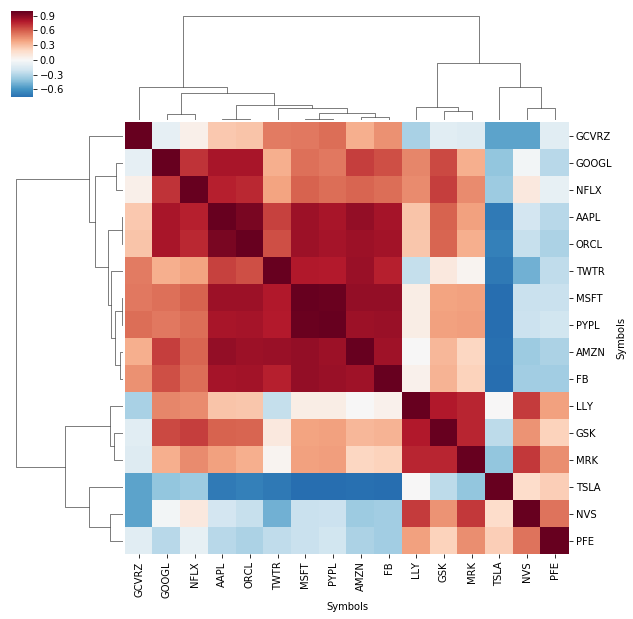

In [96]:
sns.clustermap(
    stock_close_corr,
    method='ward',
    cmap='RdBu_r',
    center=0,
    robust=True
);

## Key points:

* In general - tech stocks and pharma stocks are clustered... apart from Sanofi and Tesla!
* Microsoft and Paypal are very correlated
* There is a cluster of 3 pharma companies that look very similar

The final cells show different visualisations of these stocks:

## Plotting Microsoft and PayPal

These look incredibly highly correlated!

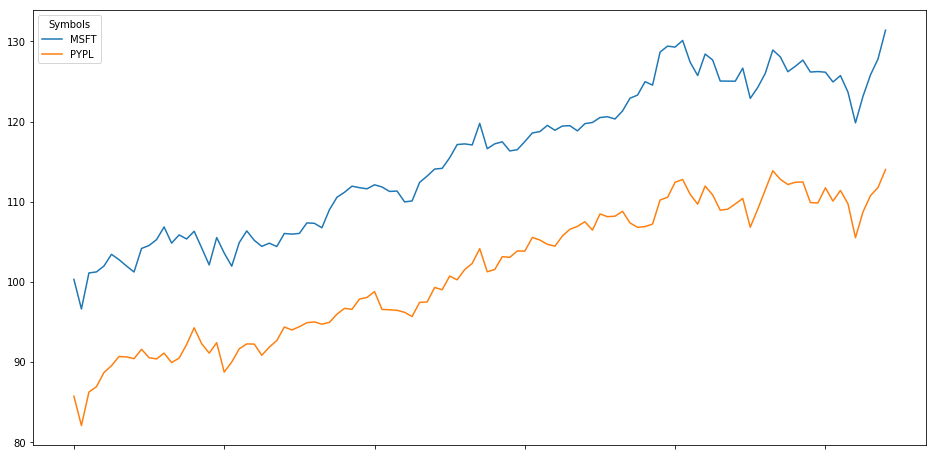

In [97]:
fig, ax = plt.subplots(figsize=(16, 8))
stock_df['close'][['MSFT', 'PYPL']].plot(ax=ax)
ax.set_xlabel('');

## Plotting Eli Lilly, Glaxo Smith-Kline, and Merck Pharma stocks

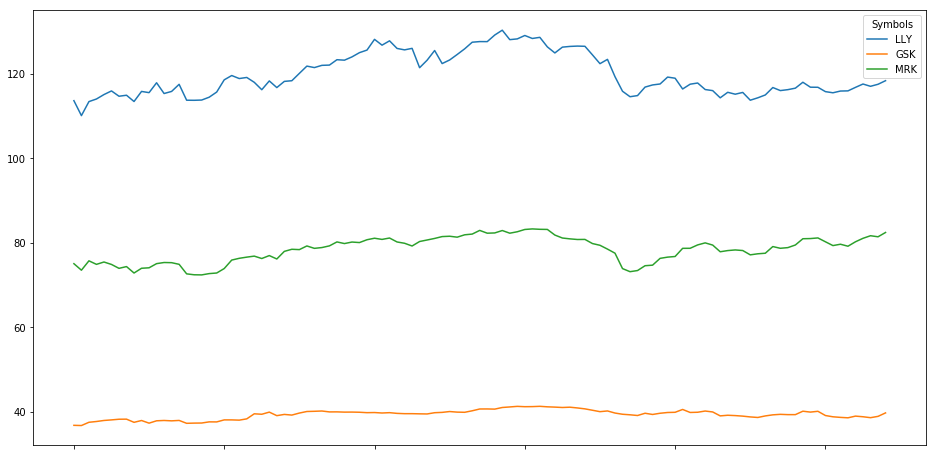

In [98]:
fig, ax = plt.subplots(figsize=(16, 8))
stock_df['close'][['LLY', 'GSK', 'MRK']].plot(ax=ax)
ax.set_xlabel('');

## What's happening with Tesla?

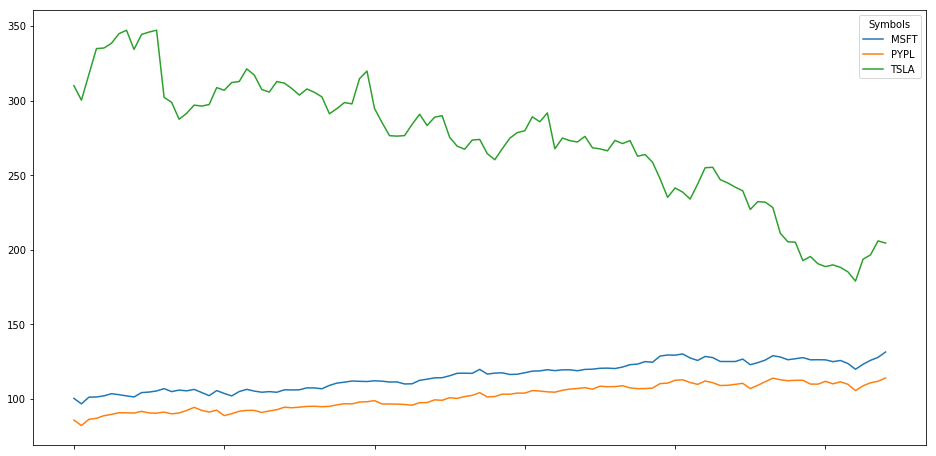

In [99]:
fig, ax = plt.subplots(figsize=(16, 8))
stock_df['close'][['MSFT', 'PYPL', 'TSLA']].plot(ax=ax)
ax.set_xlabel('');

# Extra material - DBSCAN

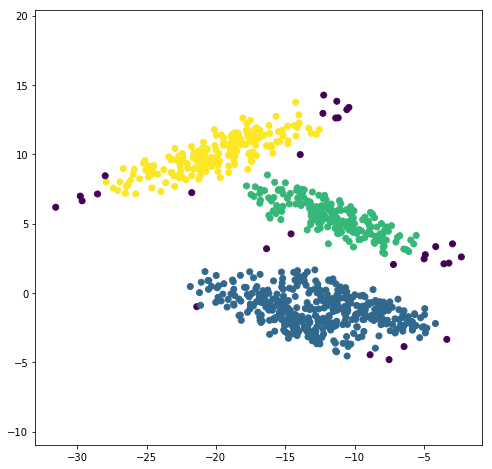

In [100]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1)

dbscan.fit(gaussian_overlap_all)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x_gaussian, y_gaussian, c=dbscan.labels_)
ax.axis('equal');

In [101]:
dbscan_signal_indices = np.argwhere(dbscan.labels_ != -1).flatten()
dbscan_signal = gaussian_overlap_all[dbscan_signal_indices]
dbscan_clusters = dbscan.labels_[dbscan_signal_indices]

silhouette_score(dbscan_signal, dbscan_clusters)

0.4707400992481944

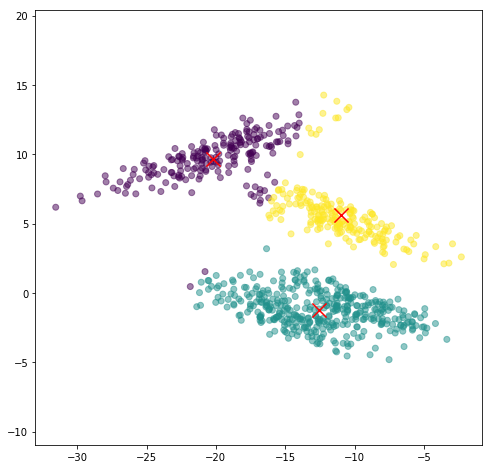

In [102]:
km3.fit(gaussian_overlap_all)
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x_gaussian, y_gaussian, c=km3.labels_, alpha=0.5)
ax.scatter(km3.cluster_centers_[:, 0], km3.cluster_centers_[:, 1], marker='x', c='red', s=200)
ax.axis('equal');

In [103]:
silhouette_score(gaussian_overlap_all, km3.labels_)

0.46743352233825575